In [37]:
import os
import sys
import cv2
import json
import math
import torch
import numpy as np
import argparse
import torchvision
import matplotlib.pyplot as plt
from typing import List, Tuple
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Methods

In [38]:
def get_slope(line):
    if line[0] == line[2]:
        return (line[1] - line[3]) / 1e-6
    else:
        return (line[1] - line[3]) / ((line[0] - line[2]))


def get_distance(p1, p2):
    return math.sqrt(pow(p1[0]-p2[0], 2) + pow(p1[1]-p2[1], 2))


def get_cut_point(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    m1 = get_slope(line1)
    m2 = get_slope(line2)
    if m1 == m2:
        return None

    x_interseccion = (m1 * x1 - y1 - m2 * x3 + y3) / (m1 - m2)
    y_interseccion = round(m1 * (x_interseccion - x1) + y1)
    x_interseccion = round(x_interseccion)

    if (x1 <= x_interseccion <= x2 or x2 <= x_interseccion <= x1) and \
       (x3 <= x_interseccion <= x4 or x4 <= x_interseccion <= x3) and \
       (y1 <= y_interseccion <= y2 or y2 <= y_interseccion <= y1) and \
       (y3 <= y_interseccion <= y4 or y4 <= y_interseccion <= y3):
        return (x_interseccion, y_interseccion)
    else:
        return None


def get_h_v_lines(lines: np.ndarray,
              min_vert_len: int = 70,
              min_horiz_len: int = 100,
              min_vert_slope: float = 1.5,
              max_horiz_slope: float = 0.01) -> Tuple[np.ndarray, np.ndarray]:
    horizontal_lines = []
    vertical_lines = []
    for line in lines:
        distance = np.sqrt((line[0] - line[2])**2 + (line[1] - line[3])**2)
        slope = get_slope(line)
        if distance > min_horiz_len and abs(slope) < max_horiz_slope:
            horizontal_lines.append(line)
        elif distance > min_vert_len and abs(slope) > min_vert_slope:
            vertical_lines.append(line)
    horizontal_lines = np.array(horizontal_lines)
    vertical_lines = np.array(vertical_lines)
    return horizontal_lines, vertical_lines


def are_overlaped(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    m1 = get_slope(line1)
    m2 = get_slope(line2)
    if m1 == m2:
        return False

    x_interseccion = (m1 * x1 - y1 - m2 * x3 + y3) / (m1 - m2)
    y_interseccion = m1 * (x_interseccion - x1) + y1

    if (x1 <= x_interseccion <= x2 or x2 <= x_interseccion <= x1) and \
       (x3 <= x_interseccion <= x4 or x4 <= x_interseccion <= x3) and \
       (y1 <= y_interseccion <= y2 or y2 <= y_interseccion <= y1) and \
       (y3 <= y_interseccion <= y4 or y4 <= y_interseccion <= y3):
        return (x_interseccion, y_interseccion)
    else:
        return False


def group_lines_by_overlap(lines):
    groups_by_overlap = []
    for line1 in lines:
        #print("\tbuscando para " + str(line1))
        if len(groups_by_overlap) == 0:
            #print("\t\tnueva linea: " + str(line1))
            groups_by_overlap.append([line1])
        else:
            overlaped_groups = []
            other_groups = []
            for group in groups_by_overlap:
                overlap = False
                for line2 in group:
                    if are_overlaped(line1, line2):
                        #print("\t\toverlap con " + str(line2))
                        overlap = True
                        break
                if overlap is True:
                    overlaped_groups.append(group)
                else:
                    other_groups.append(group)
            if len(overlaped_groups) == 0:
                new_group = [line1]
            else:
                new_group = [line1]
                for group in overlaped_groups:
                    new_group.extend(group)
                #print("\tnuevo grupo: " + str(new_group))
            groups_by_overlap = other_groups
            groups_by_overlap.append(new_group)
        #print(line_groups)
    return groups_by_overlap


def unify_lines(lines):
    u_line = None
    for line in lines:
        if u_line is None:
            if line[1] > line[3]:
                u_line = line
            else:
                u_line = [line[2], line[3], line[0], line[1]]
        else:
            if line[1] > u_line[1]:
                u_line[0], u_line[1] = line[0], line[1]
            if line[3] > u_line[1]:
                u_line[0], u_line[1] = line[2], line[3]
            if line[1] < u_line[3]:
                u_line[2], u_line[3] = line[0], line[1]
            if line[3] < u_line[3]:
                u_line[2], u_line[3] = line[2], line[3]
    return u_line


def unify_lines_by_cuts(lines, grid_tam, n_cutting_lines=10, sensitivity=10):
    cutting_lines = []
    cutting_line_h = grid_tam[1] / (n_cutting_lines + 1)
    for i in range(1, n_cutting_lines + 1):
        cutting_lines.append([0, int(cutting_line_h * i), grid_tam[0], int(cutting_line_h * i)])

    to_unify_dict = {}
    for i in range(len(lines)):
        to_unify_dict[i] = lines[i]

    for cutting_line in cutting_lines:
        #print("Cutting line: " + str(cutting_line))
        for i in range(len(lines)):
            for j in range(i+1, len(lines)):
                line_i = to_unify_dict.get(i, None)
                line_j = to_unify_dict.get(j, None)
                if line_i is not None and line_j is not None:
                    #print("  Probando " + str(i) + "=" + str(line_i) + " | " + str(j) + "=" + str(line_j))
                    p1 = get_cut_point(line_i, cutting_line)
                    p2 = get_cut_point(line_j, cutting_line)
                    if p1 is not None and p2 is not None:
                        #print("    Distancia entre " + str(i) + " y " + str(j) + ": " + str(get_distance(p1, p2)))
                        if p1 is not None and p2 is not None and get_distance(p1, p2) < sensitivity:
                            #print("      Unificando " + str(i) + "=" + str(line_i) + " | " + str(j) + "=" + str(line_j) + " | " + str(get_distance(p1, p2)))
                            to_unify_dict[i] = unify_lines([line_i, line_j])
                            to_unify_dict[j] = None
                            #print("      Resultado: " + str(to_unify_dict[i]) + " | " + str(to_unify_dict[j]))

    unifyed_list = []
    for unifyed_line in to_unify_dict.values():
        if unifyed_line is not None:
            unifyed_list.append(list(unifyed_line))

    return unifyed_list


def reshape_square(square):
	return [square[0], square[3], square[2], square[1]]


def get_square_size(square):
    return abs((square[2] - square[0]) * (square[3] - square[1]))


def sort_boxes_by_size(boxes):
    return sorted(boxes, key=get_square_size, reverse=True)


def create_homography(points_src, points_dst):
	if isinstance(points_src, list):
		points_src = np.array(points_src, dtype=np.float32)
	if isinstance(points_dst, list):
		points_dst = np.array(points_dst, dtype=np.float32)
	h, _ = cv2.findHomography(points_src, points_dst)
	return h


def find_homography(homography, points, to_int=True):
	aux = np.array(points, dtype=np.float32).reshape(-1, 1, 2)
	np_type = np.int32 if to_int is True else np.float32
	return np.array(cv2.perspectiveTransform(aux, homography)[:, 0], dtype=np_type)


def get_foot_from_square(square):
	x = int(square[0] + (square[2] - square[0]) / 2)
	y = square[1]
	return [x, y]


def sort_boxes_by_y(boxes):
    def get_y(box):
        return box[1]
    return sorted(boxes, key=get_y, reverse=True)

In [39]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for x1, y1, x2, y2 in lines:
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    # Return the modified image.
    return img


def draw_boxes(img, boxes, color=[255, 0, 0]):
    lines = []
    for box in boxes:
        lines.append([box[0], box[1], box[2], box[1]])
        lines.append([box[2], box[1], box[2], box[3]])
        lines.append([box[2], box[3], box[0], box[3]])
        lines.append([box[0], box[3], box[0], box[1]])

    return draw_lines(img, lines, color=color)

# Main

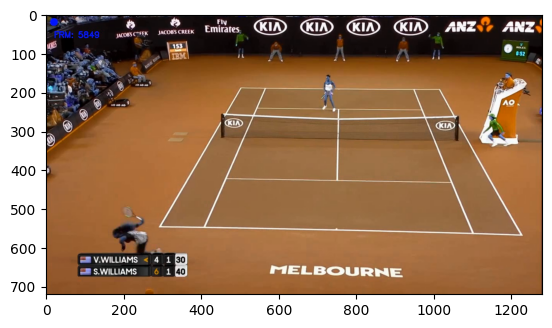

In [40]:
#img_path = "0.png"
#img_path = "2.png"
#img_path = "109.png"#
#img_path = "169.png"#
#img_path = "262.png"
#img_path = "297.png"#
#img_path = "366.png"#
#img_path = "374.png"
#img_path = "437.png"
#img_path = "1906.png"
#img_path = "556.png"
#img_path = "290.png"

#img_path = "115.png"
img_path = "3.png"


img_original = cv2.imread(img_path)

import random
max_d = 20
red = [[411, 815], [221, 817]]
green = []
for p_red in red:
    for i in range(9):
        green.append([p_red[0] + random.randint(-max_d, max_d),
                      p_red[1] + random.randint(-max_d, max_d)])


plt.imshow(img_original)
#for p in green:
#    plt.scatter(p[0], p[1], c='g')
#for p in red:
#    plt.scatter(p[0], p[1], c='r')

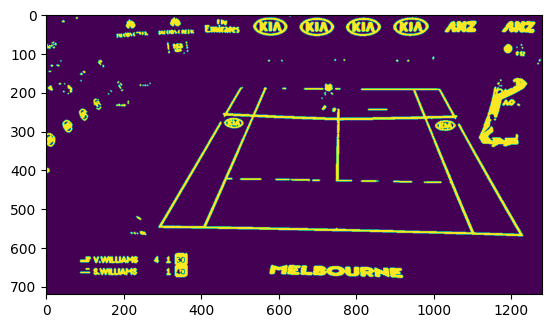

In [41]:
img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
img_gray = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)[1]

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
img_gray = cv2.dilate(img_gray, kernel=kernel, iterations=2)


plt.imshow(img_gray)

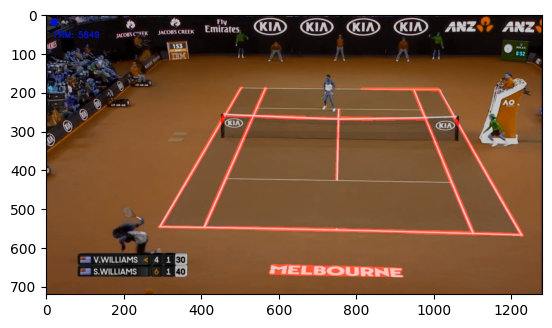

In [42]:
lines_hough = cv2.HoughLinesP(img_gray,
                              rho=1,
                              theta=np.pi / 180,
                              threshold=80,
                              minLineLength=img_original.shape[0] * 0.25,
                              maxLineGap=img_original.shape[0] * 0.03)
lines_hough = lines_hough.squeeze()

img_empty = np.full((img_original.shape[0], img_original.shape[1]), 0, dtype=np.uint8)

image_lines = draw_lines(img_original, lines_hough)
plt.imshow(image_lines)

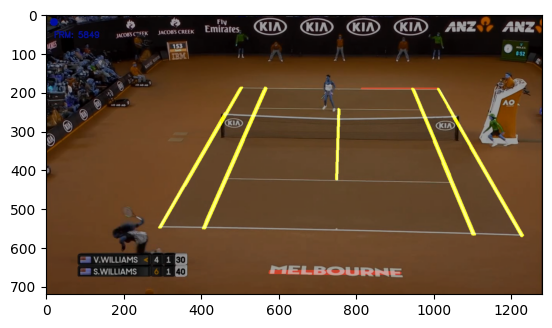

In [43]:
horizontal_lines, vertical_lines = get_h_v_lines(lines_hough)
image_lines = draw_lines(img_original, horizontal_lines)
image_lines = draw_lines(image_lines, vertical_lines, color=[255, 255, 0])


plt.imshow(image_lines)

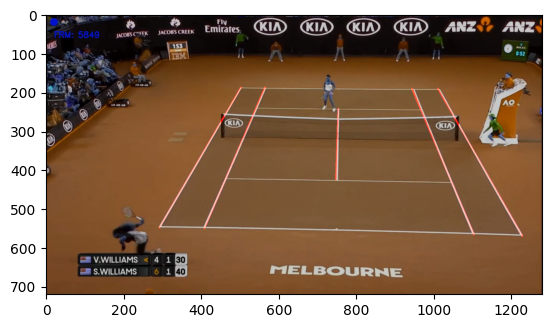

In [44]:
groups_by_cuts = unify_lines_by_cuts(vertical_lines, [img_original.shape[1], img_original.shape[0]])

court_lines = []
for line in groups_by_cuts:
    court_lines.append(line)


image_lines = draw_lines(img_original, court_lines)
plt.imshow(image_lines)

[[408, 551], [1104, 567], [944, 191], [565, 188]]
[[292, 549], [1229, 571], [1011, 191], [503, 188]]


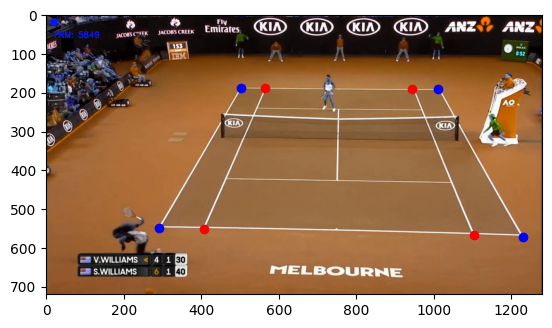

In [45]:
sorted_court_lines = sorted(court_lines, key=lambda line: line[0])
court_points_singles = [sorted_court_lines[1][:2], sorted_court_lines[-2][:2],
                        sorted_court_lines[-2][2:], sorted_court_lines[1][2:]]
court_points_doubles = [sorted_court_lines[0][:2], sorted_court_lines[-1][:2],
                        sorted_court_lines[-1][2:], sorted_court_lines[0][2:]]

print(court_points_singles)
print(court_points_doubles)

plt.imshow(img_original)
for p in court_points_singles:
    plt.scatter(p[0], p[1], c='r')
for p in court_points_doubles:
    plt.scatter(p[0], p[1], c='b')

# Homography

In [46]:
topview_points_singles = np.array([[5.37, 30.97], [13.6, 30.97], [13.6, 8], [5.37, 8]], dtype=np.float32)
topview_points_doubles = np.array([[4, 30.97], [14.97, 30.97], [14.97, 8], [4, 8]], dtype=np.float32)

h_to_topview = create_homography(court_points_singles, topview_points_singles)
h_to_court = create_homography(topview_points_singles, court_points_singles)

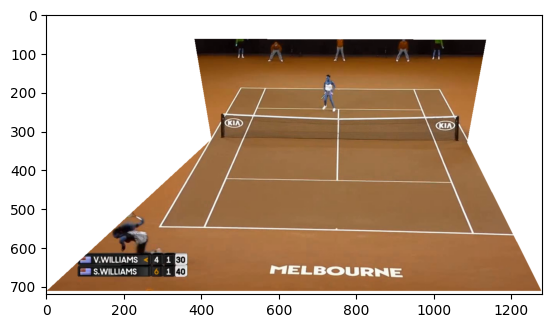

In [47]:
mask_topview_points = np.array([[4, 19.885], [14.97, 19.885], # middle points
                                [18.97, 0], [0, 0],
                                [0, 36]], dtype=np.float32).reshape(-1, 1, 2) # top points
mask_courtview_points = np.array(cv2.perspectiveTransform(mask_topview_points, h_to_court)[:, 0], dtype=np.int32)
"""
mask_top_points = np.array([[0, mask_courtview_points[0][1]],
                            mask_courtview_points[0], [mask_courtview_points[3][0], mask_courtview_points[3][1]/2],
                            [mask_courtview_points[2][0], mask_courtview_points[2][1]/2], mask_courtview_points[1],
                            [img_original.shape[1], mask_courtview_points[1][1]], [img_original.shape[1], 0], [0, 0]], dtype=np.int32)
"""
mask_top_points = np.array([[0, mask_courtview_points[4][1]],
                            mask_courtview_points[0], [mask_courtview_points[3][0], mask_courtview_points[3][1]/2],
                            [mask_courtview_points[2][0], mask_courtview_points[2][1]/2], mask_courtview_points[1],
                            [img_original.shape[1], mask_courtview_points[4][1]], [img_original.shape[1], 0], [0, 0]], dtype=np.int32)

mask_bottom_points = np.array([[0, img_original.shape[0]], [img_original.shape[1], img_original.shape[0]],
                               [img_original.shape[1], mask_courtview_points[4][1]], [0, mask_courtview_points[4][1]]], dtype=np.int32)

img_masked = np.copy(img_original)
cv2.fillPoly(img_masked , [mask_top_points] , (255,255,255))
cv2.fillPoly(img_masked , [mask_bottom_points] , (255,255,255))
plt.imshow(img_masked)

# Players

##RCNN

In [48]:
model_url = "FasterRCNN_ResNet50_FPN_Weights.DEFAULT"
PEOPLE_DETECTION_MODEL = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
PEOPLE_DETECTION_MODEL.type(torch.FloatTensor)
PEOPLE_DETECTION_MODEL.eval()

PERSON_LABEL = 1
PERSON_MIN_SCORE = 0.20
FRAMES_TO_COPY = 5

In [49]:
processed = img_masked.transpose((2, 0, 1)) / 255
#processed = img_original.transpose((2, 0, 1)) / 255
processed = torch.from_numpy(processed).unsqueeze(0).type(torch.FloatTensor)

with torch.no_grad():
    result = PEOPLE_DETECTION_MODEL(processed)

persons_boxes = []
for box, label, score in zip(result[0]['boxes'][:],
    result[0]['labels'], result[0]['scores']):
    if label == PERSON_LABEL and score > PERSON_MIN_SCORE:
        persons_boxes.append(reshape_square(box.detach().cpu().numpy().astype(int)))

print(persons_boxes)

[[709, 245, 747, 155], [903, 126, 938, 66], [572, 124, 613, 70], [994, 118, 1026, 64], [740, 124, 772, 65], [489, 115, 512, 64], [174, 610, 263, 516], [495, 114, 511, 81]]


##YOLO

In [ ]:
YOLO_MODEL = torch.hub.load('ultralytics/yolov5:master', 'yolov5s', pretrained=True)

In [ ]:
processed = cv2.cvtColor(img_masked, cv2.COLOR_BGR2RGB)

result = YOLO_MODEL(processed)

persons_boxes = []
for xyxy in result.xyxy[0]:
    if xyxy[-1] == 0 and xyxy[-2] > 0.2:
        box = [int(c) for c in xyxy[:4]]
        persons_boxes.append(reshape_square(box))

print(persons_boxes)

##Postprocess

[[709, 245, 747, 155], [903, 126, 938, 66], [572, 124, 613, 70], [994, 118, 1026, 64], [740, 124, 772, 65], [489, 115, 512, 64], [495, 114, 511, 81]]
[[174, 610, 263, 516]]


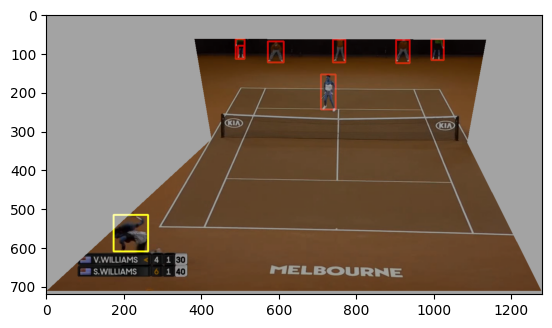

In [50]:
middle =  find_homography(h_to_court, [[9.485, 19.885]])[0]

top_boxes = [box for box in persons_boxes if box[1] <= middle[1]]
bottom_boxes = [box for box in persons_boxes if box[1] > middle[1]]

print(top_boxes)
print(bottom_boxes)

aux_img = draw_boxes(img_masked, top_boxes, [255, 0, 0])
#aux_img = draw_boxes(img_original, top_boxes, [255, 0, 0])
aux_img = draw_boxes(aux_img, bottom_boxes, [255, 255, 0])
plt.imshow(aux_img)
#for box in top_boxes:
#    foot = get_foot_from_square(box)
#    plt.scatter(foot[0], foot[1], c='r')
#for box in bottom_boxes:
#    foot = get_foot_from_square(box)
#    plt.scatter(foot[0], foot[1], c='y')

[709, 245, 747, 155]
[174, 610, 263, 516]
----
[728, 245]
[218, 610]


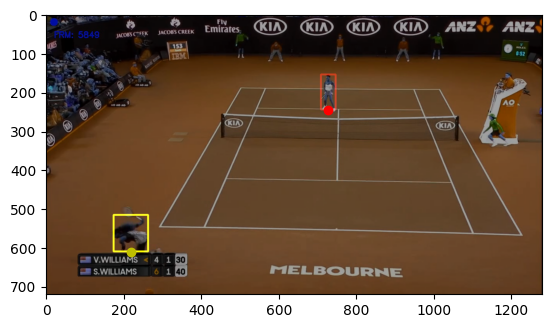

In [51]:
top_box = sort_boxes_by_y(top_boxes)[0]
bottom_box = sort_boxes_by_y(bottom_boxes)[-1]

top_player = get_foot_from_square(top_box)
bottom_player = get_foot_from_square(bottom_box)

print(top_box)
print(bottom_box)

print("----")

print(top_player)
print(bottom_player)

pts = [top_player, bottom_player]

aux_img = np.copy(img_original)
#aux_img = np.copy(img_masked)
aux_img = draw_boxes(aux_img, [top_box], [255, 0, 0])
aux_img = draw_boxes(aux_img, [bottom_box], [255, 255, 0])
plt.imshow(aux_img)
plt.scatter(top_player[0], top_player[1], c='r')
plt.scatter(bottom_player[0], bottom_player[1], c='y')

#Representacion

In [ ]:
plt.imshow(img_original)

plt.scatter(top_player[0], top_player[1], c='r')
plt.scatter(bottom_player[0], bottom_player[1], c='y')

for p in court_points_singles:
    plt.scatter(p[0], p[1], c='r')
for p in court_points_doubles:
    plt.scatter(p[0], p[1], c='b')

In [ ]:
def get_circle_points(coord, radius, n_points):
    x, y = coord
    angulo = 2 * math.pi / n_points

    puntos = []
    for i in range(n_points):
        nuevo_x = x + radius * math.cos(i * angulo)
        nuevo_y = y + radius * math.sin(i * angulo)
        puntos.append([nuevo_x, nuevo_y])

    return puntos


def get_elipse_points(coord, a, b, n_points):
    x, y = coord
    angulo = 2 * math.pi / n_points

    puntos = []
    for i in range(n_points):
        nuevo_x = x + a * math.cos(i * angulo)
        nuevo_y = y + b * math.sin(i * angulo)
        puntos.append([nuevo_x, nuevo_y])

    return puntos


player_cameraview_coord = bottom_player
#player_cameraview_coord = top_player

player_topview_coord = find_homography(h_to_topview, player_cameraview_coord, to_int=False)[0]
topview_circle = get_circle_points(player_topview_coord, radius=5, n_points=15)
cameraview_circle = find_homography(h_to_court, topview_circle)


plt.imshow(img_original)
plt.scatter(bottom_player[0], bottom_player[1], c='y')
for p in cameraview_circle:
    plt.scatter(p[0], p[1], c='r')

In [ ]:
def get_area_lines(area):
    lines = []
    for i in range(len(area)):
        next_i = (i + 1) % len(area)
        line = [area[i][0], area[i][1], area[next_i][0], area[next_i][1]]
        lines.append(line)
    return lines


def draw_circunference(img_original, pts, color):
    img_painted = np.copy(img_original)
    return draw_lines(img_painted, get_area_lines(pts))


img_painted = draw_circunference(img_original, cameraview_circle, color=[255, 0, 0])
plt.imshow(img_painted)

In [ ]:
def draw_area(img_original, pts, color):
    img_painted = np.copy(img_original)

    reshaped_pts = np.array(pts, np.int32)
    reshaped_pts = reshaped_pts.reshape((-1, 1, 2))

    paint_mask = np.zeros(img_original.shape[:2], dtype=np.uint8)
    cv2.fillPoly(paint_mask, [reshaped_pts], 255)

    mascara = np.zeros(img_painted.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mascara, [reshaped_pts], 255)

    for i_RGB, variation in zip([0, 1, 2], color):
        img_painted[:, :, i_RGB] = np.where(mascara == 255, img_painted[:, :, i_RGB] * variation, img_painted[:, :, i_RGB])

    return img_painted

print(cameraview_circle)

color_variation = [0.5, 0.5, 1.5] # to blue
#color_variation = [1.5, 0.5, 0.5] # to red
img_painted = draw_area(img_original, cameraview_circle, color_variation)
plt.imshow(img_painted)

In [ ]:
def is_point_inside(pt, area):
    aux_line = [0, 0, pt[0], pt[1]]

    area_lines = get_area_lines(area)
    n_cuts = 0

    for line in area_lines:
        c_point = get_cut_point(aux_line, line)
        if c_point is not None and not (c_point[0] == line[0] and c_point[1] == line[1]):
            n_cuts += 1

    if n_cuts % 2 == 0:
        return False
    else:
        return True


def cut_area_with_court(area, court_points):
    area_lines = get_area_lines(area)
    court_lines = get_area_lines(court_points)

    new_area = []
    inside = is_point_inside(area[0], court_points)
    for line in area_lines:
        # Si esta dentro aniade el inicio de la linea
        if inside is True:
            new_area.append([line[0], line[1]])
        # Comprueba si hay corte con las lineas de pista
        for c_line in court_lines:
            cut_p = get_cut_point(line, c_line)
            # Si hay corte aniade el punto
            if cut_p is not None and (len(new_area) == 0 or (len(new_area) > 0 and cut_p != new_area[-1])):
                if inside is False:
                    inside = True
                    if is_point_inside(c_line[:2], area):
                        new_area.append(c_line[:2])
                    else:
                        new_area.append(c_line[2:])
                    new_area.append(cut_p)
                else:
                    inside = False
                    new_area.append(cut_p)
                    if is_point_inside(c_line[:2], area):
                        new_area.append(c_line[:2])
                    else:
                        new_area.append(c_line[2:])

    if len(new_area) == 0:
        if inside is True:
            new_area = area
        elif is_point_inside(court_points[0], area) is True:
            new_area = court_points

    return new_area


new_area = cut_area_with_court(cameraview_circle, court_points_singles)
print(new_area)


color_variation = [1.5, 0.5, 0.5] # to red
img_painted = draw_area(img_original, new_area, color_variation)
plt.imshow(img_painted)

In [ ]:
player_cameraview_coord = bottom_player
#player_cameraview_coord = top_player


middle_court_points = find_homography(h_to_court, [[5.37, 19.885], [13.6, 19.885]])
bottom_cout_points = [court_points_singles[0], court_points_singles[1], middle_court_points[1], middle_court_points[0]]
top_court_points = [middle_court_points[0], middle_court_points[1], court_points_singles[2], court_points_singles[3]]


player_topview_coord = find_homography(h_to_topview, player_cameraview_coord, to_int=False)[0]

#circles = [{"radius": 3.5, "n": 10, "color": "r"},
#           {"radius": 6,   "n": 10, "color": "y"}]

circles = [{"a": 3, "b": 8, "n": 15, "color": "r"},
           {"a": 5, "b": 10, "n": 15, "color": "y"}]

for c in circles:
    #topview_points = get_circle_points(player_topview_coord, radius=c["radius"], n_points=c["n"])
    topview_points = get_elipse_points(player_topview_coord, a=c["a"], b=c["b"], n_points=c["n"])
    points = find_homography(h_to_court, topview_points)
    #c["points"] = cut_area_with_court(points, court_points_singles)
    c["points"] = cut_area_with_court(points, bottom_cout_points)
    #c["points"] = cut_area_with_court(points, top_court_points)

#circles.append({"points": bottom_cout_points, "color": "g"})

colors = {"r": {"color": [3/2, 1/2, 1/2], "not": [2/3, 2,   2]},
          "y": {"color": [3/2, 3/2, 1/2], "not": [2/3, 2/3, 2]},
          "g": {"color": [1/2, 3/2, 1/2], "not": [2,   2/3, 2]},
          "b": {"color": [1/2, 1/2, 3/2], "not": [2,   2,   2/3]}}

img_painted = np.copy(img_original)
sig_not = None
for circle in reversed(circles):
    if sig_not is not None:
        img_painted = draw_area(img_painted, circle["points"], sig_not)
    img_painted = draw_area(img_painted, circle["points"], colors[circle["color"]]["color"])
    sig_not = colors[circle["color"]]["not"]
plt.imshow(img_painted)

#Ball detection

In [ ]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pad, bias=True, bn=True):
        super().__init__()
        if bn:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=pad, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=pad, bias=bias),
                nn.ReLU()
            )

    def forward(self, x):
        return self.block(x)


class BallTrackerNet(nn.Module):
    """
    Deep network for ball detection
    """
    def __init__(self, out_channels=256, bn=True):
        super().__init__()
        self.out_channels = out_channels

        # Encoder layers
        layer_1 = ConvBlock(in_channels=9, out_channels=64, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_2 = ConvBlock(in_channels=64, out_channels=64, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_3 = nn.MaxPool2d(kernel_size=2, stride=2)
        layer_4 = ConvBlock(in_channels=64, out_channels=128, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_5 = ConvBlock(in_channels=128, out_channels=128, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_6 = nn.MaxPool2d(kernel_size=2, stride=2)
        layer_7 = ConvBlock(in_channels=128, out_channels=256, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_8 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_9 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_10 = nn.MaxPool2d(kernel_size=2, stride=2)
        layer_11 = ConvBlock(in_channels=256, out_channels=512, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_12 = ConvBlock(in_channels=512, out_channels=512, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_13 = ConvBlock(in_channels=512, out_channels=512, kernel_size=3, pad=1, bias=True, bn=bn)

        self.encoder = nn.Sequential(layer_1, layer_2, layer_3, layer_4, layer_5, layer_6, layer_7, layer_8, layer_9,
                                     layer_10, layer_11, layer_12, layer_13)

        # Decoder layers
        layer_14 = nn.Upsample(scale_factor=2)
        layer_15 = ConvBlock(in_channels=512, out_channels=256, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_16 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_17 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_18 = nn.Upsample(scale_factor=2)
        layer_19 = ConvBlock(in_channels=256, out_channels=128, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_20 = ConvBlock(in_channels=128, out_channels=128, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_21 = nn.Upsample(scale_factor=2)
        layer_22 = ConvBlock(in_channels=128, out_channels=64, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_23 = ConvBlock(in_channels=64, out_channels=64, kernel_size=3, pad=1, bias=True, bn=bn)
        layer_24 = ConvBlock(in_channels=64, out_channels=self.out_channels, kernel_size=3, pad=1, bias=True, bn=bn)

        self.decoder = nn.Sequential(layer_14, layer_15, layer_16, layer_17, layer_18, layer_19, layer_20, layer_21,
                                     layer_22, layer_23, layer_24)

        self.softmax = nn.Softmax(dim=1)
        self._init_weights()

    def forward(self, x, testing=False):
        batch_size = x.size(0)
        features = self.encoder(x)
        scores_map = self.decoder(features)
        output = scores_map.reshape(batch_size, self.out_channels, -1)
        # output = output.permute(0, 2, 1)
        if testing:
            output = self.softmax(output)
        return output

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.uniform_(module.weight, -0.05, 0.05)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

    def inference(self, frames: torch.Tensor):
        self.eval()
        with torch.no_grad():
            if len(frames.shape) == 3:
                frames = frames.unsqueeze(0)
            if next(self.parameters()).is_cuda:
                frames.cuda()
            # Forward pass
            output = self(frames) #testing=True
            output = output.argmax(dim=1).detach().cpu().numpy()
            if self.out_channels == 2:
                output *= 255
            x, y = self.get_center_ball(output)
        #return x, y
        return output

    def get_center_ball(self, output):
        """
        Detect the center of the ball using Hough circle transform
        :param output: output of the network
        :return: indices of the ball`s center
        """
        output = output.reshape((360, 640))

        # cv2 image must be numpy.uint8, convert numpy.int64 to numpy.uint8
        output = output.astype(np.uint8)

        # reshape the image size as original input image
        heatmap = cv2.resize(output, (640, 360))

        # heatmap is converted into a binary image by threshold method.
        ret, heatmap = cv2.threshold(heatmap, 127, 255, cv2.THRESH_BINARY)

        # find the circle in image with 2<=radius<=7
        circles = cv2.HoughCircles(heatmap, cv2.HOUGH_GRADIENT, dp=1, minDist=1, param1=50, param2=2, minRadius=2,
                                   maxRadius=7)
        # check if there have any tennis be detected
        if circles is not None:
            # if only one tennis be detected
            if len(circles) == 1:
                x = int(circles[0][0][0])
                y = int(circles[0][0][1])

                return x, y
        return None, None

In [ ]:
def combine_three_frames(frame1, frame2, frame3, width, height):
    """
    Combine three frames into one input tensor for detecting the ball
    """

    # Resize and type converting for each frame
    img = cv2.resize(frame1, (width, height))
    # input must be float type
    img = img.astype(np.float32)

    # resize it
    img1 = cv2.resize(frame2, (width, height))
    # input must be float type
    img1 = img1.astype(np.float32)

    # resize it
    img2 = cv2.resize(frame3, (width, height))
    # input must be float type
    img2 = img2.astype(np.float32)

    # combine three imgs to  (width , height, rgb*3)
    imgs = np.concatenate((img, img1, img2), axis=2)

    # since the odering of TrackNet  is 'channels_first', so we need to change the axis
    imgs = np.rollaxis(imgs, 2, 0)

    return (torch.from_numpy(np.array(imgs)) / 255).to(torch.device("cpu"))


def combine_frames(frames_list, width, height):
    pre_frames_list = []
    for frame in frames_list:
        # resize it
        pre_frame = cv2.resize(frame, (width, height))
        # input must be float type
        pre_frame = pre_frame.astype(np.float32)

        pre_frames_list.append(pre_frame)

    # combine imgs to  (width , height, rgb*3)
    combined = np.concatenate(tuple(pre_frames_list), axis=2)

    # since the odering of TrackNet  is 'channels_first', so we need to change the axis
    combined = np.rollaxis(combined, 2, 0)

    return (torch.from_numpy(np.array(combined)) / 255).to(torch.device("cpu"))


last_frames = []
for last_img in reversed(["113.png", "114.png"]):
    last_frames.append(cv2.imread(last_img))
combined_three_frames = combine_three_frames(img_original, last_frames[0], last_frames[1], 640, 360)


last_frames = []
for last_img in reversed(["113.png", "113.png", "114.png", "114.png", "115.png", "115.png"]):
    last_frames.append(cv2.imread(last_img))
combined_multiple_frames = combine_three_frames(last_frames, 640, 360)

combined_frames = combined_multiple_frames

In [ ]:
BALL_DETECTOR = BallTrackerNet(out_channels=2)
saved_state_dict = torch.load("tracknet_weights_2_classes.pth", map_location=torch.device('cpu'))
BALL_DETECTOR.load_state_dict(saved_state_dict['model_state'])
BALL_DETECTOR.eval().to(torch.device("cpu"))

print("")

In [ ]:
output = BALL_DETECTOR.inference(combined_frames)
x, y = BALL_DETECTOR.get_center_ball(output)

if x is not None:
    x = x * (img_original.shape[1] / 640)
    y = y * (img_original.shape[0] / 360)
    plt.scatter(x, y, c='r')

    ball = [x, y]

print(x)
print(y)

plt.imshow(img_original)

#Stroke detection

In [ ]:
import imutils
from torchvision import transforms

STROKE_MODEL = torchvision.models.inception_v3(pretrained=True)
STROKE_MODEL.type(torch.FloatTensor)
STROKE_MODEL.eval()

print("")

In [ ]:
def get_image_from_box(image, box):
	margin = [int((box[2] - box[0]) * 1.5),
			  int((box[1] - box[3]) * 0.4)]

	box_center = [((box[2] - box[0]) / 2) + box[0],
				  ((box[1] - box[3]) / 2) + box[3]]

	#box_coords = [[int(box_center[0] - margin[0]), int(box_center[1] + margin[1])],
	#			  [int(box_center[0] + margin[0]), int(box_center[1] + margin[1])],
	#			  [int(box_center[0] + margin[0]), int(box_center[1] - margin[1])],
	#			  [int(box_center[0] - margin[0]), int(box_center[1] - margin[1])]]
	box_coords = [[0, int(box_center[1] + margin[1])],
				  [image.shape[1], int(box_center[1] + margin[1])],
				  [image.shape[1], int(box_center[1] - margin[1])],
				  [0, int(box_center[1] - margin[1])]]

	#new_image = image[int(box_center[1] - margin[1]):int(box_center[1] + margin[1]),
	#			       int(box_center[0] - margin[0]):int(box_center[0] + margin[0])].copy()
	new_image = image[int(box_center[1] - margin[1]):int(box_center[1] + margin[1]),
				      0:image.shape[1]].copy()

	return new_image, box_coords


#player_box = top_box
player_box = bottom_box

player_img, player_img_coords = get_image_from_box(img_original, player_box)

print(player_img_coords)
print(ball)

print(is_point_inside(ball, player_img_coords))

plt.imshow(player_img)

##Stroke classification

In [ ]:
def preprocess_image(image):
    new_image = imutils.resize(image, 299)
    new_image = new_image.transpose((2, 0, 1)) / 255
    image_tensor = torch.from_numpy(new_image).type(torch.FloatTensor)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    image_tensor = normalize(image_tensor).unsqueeze(0)

    return image_tensor

player_tensor = preprocess_image(player_img)

with torch.no_grad():
    resultado1 = STROKE_MODEL(player_tensor)
resultado1 = resultado1.unsqueeze(1)


In [ ]:
saved_state = torch.load("storke_classifier_weights.pth", map_location=torch.device('cpu'))
model_state = saved_state["model_state"]

keys = list(model_state.keys()).copy()
for key in keys:
    if "LSTM." in key:
        new_key = key.replace("LSTM.", "")
        model_state[new_key] = model_state[key]
        del (model_state[key])
del (model_state["fc.weight"])
del (model_state["fc.bias"])


num_classes = 3
input_size = 2048
num_layers = 3
hidden_size = 90

LSTM = nn.LSTM(input_size, hidden_size, num_layers, bias=True, batch_first=True)
LSTM.load_state_dict(saved_state["model_state"])
LSTM.eval()
LSTM.type(torch.FloatTensor)

In [ ]:
softmax = nn.Softmax(dim=1)
fc = nn.Linear(hidden_size, num_classes)

#with torch.no_grad():
#    scores = LSTM(resultado1)[-1][0].unsqueeze(0)
#    probs = softmax(scores).squeeze().cpu().numpy()


batch_size = resultado1.size(0) // 4

with torch.no_grad():
    resultado2, _ = LSTM(resultado1)
    resultado2 = resultado2[:, -resultado1.size(1):, :]
    scores = fc(resultado2.squeeze(0))

scores = scores[-1].unsqueeze(0)

with torch.no_grad():
    probs = softmax(scores).squeeze().cpu().numpy()


strokes_label = ['Forehand', 'Backhand', 'Service/Smash']

print(np.argmax(probs))

print(probs)

#Fotos memoria / diagrama

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_values = [[5, 3], [1, 8]]

# Crea el mapa de calor utilizando Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=2)
sns.heatmap(cm_values, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=False, yticklabels=["True", "False"])

# Añade etiquetas y título
plt.title('Matriz de Confusión')

# Muestra la matriz de confusión
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Valor de accuracy
accuracy = 0.8
a = 0.8
p = 0.7
r = 0.75

# Configuración de los valores para la barra
valores = [a, p, r]
etiquetas = ["Accuracy", "Precision", "Recall"]

# Configura el gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(etiquetas, valores, color='skyblue')

# Añade un título y etiquetas
plt.ylim(0, 1)  # Establece el límite del eje y de 0 a 1 para representar el rango de accuracy

# Muestra el gráfico
plt.show()